# Performance comparison

This notebook compares the performance of `cuDF` and `pandas`. The comparisons performed are on identical data sizes. This notebook primarily showcases the factor
of speedups users can have when the similar `pandas` APIs are run on GPUs using `cudf`.

The hardware details used to run these performance comparisons are at the end of this page.

**Note**: This notebook is written to measure performance on NVIDIA GPUs with large memory. If running on hardware with lower memory, please consider lowering the `num_rows` values. Performance results may vary by data size, as well as the CPU and GPU used.

In [1]:
import os
import time
import timeit
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cudf

print(f"{cudf.__version__=}")

cudf.__version__='24.04.01'


In [2]:
np.random.seed(0)

## Concat, count & joins performance

In [3]:
timeit_number = 30
num_rows = 100_000_000
sub_sample = int(num_rows / 30)
num_rows

100000000

In [4]:
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(-1000, 1000, num_rows, dtype="int64"),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=num_rows
        ),
    }
)
pdf

,numbers,business
0,-316,McD
1,-441,Buckees
2,653,McD
3,216,McD
4,-165,McD
...,...,...
99999995,-125,Walmart
99999996,877,Buckees
99999997,74,Walmart
99999998,-133,McD


In [5]:
gdf = cudf.from_pandas(pdf)
gdf

,numbers,business
0,-316,McD
1,-441,Buckees
2,653,McD
3,216,McD
4,-165,McD
...,...,...
99999995,-125,Walmart
99999996,877,Buckees
99999997,74,Walmart
99999998,-133,McD


In [7]:
def timeit_pandas_cudf(pd_obj, gd_obj, func, **kwargs):
    """
    A utility function to measure execution time of an
    API(`func`) in pandas & cudf.

    Parameters
    ----------
    pd_obj : Pandas object
    gd_obj : cuDF object
    func : callable
    """
    pandas_time = timeit.timeit(lambda: func(pd_obj), **kwargs)
    cudf_time = timeit.timeit(lambda: func(gd_obj), **kwargs)
    return pandas_time, cudf_time

In [7]:
pandas_value_counts, cudf_value_counts = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.value_counts(), number=timeit_number
)

In [8]:
pdf = pdf.head(sub_sample)
gdf = gdf.head(sub_sample)

In [9]:
pandas_concat = timeit.timeit(
    lambda: pd.concat([pdf, pdf, pdf]), number=timeit_number
)

In [10]:
cudf_concat = timeit.timeit(
    lambda: cudf.concat([gdf, gdf, gdf]), number=timeit_number
)

In [11]:
pandas_groupby, cudf_groupby = timeit_pandas_cudf(
    pdf,
    gdf,
    lambda df: df.groupby("business").agg(["min", "max", "mean"]),
    number=timeit_number,
)

In [12]:
pdf = pd.DataFrame(
    {
        "numbers": np.random.randint(
            -1000, 1000, int(sub_sample / 10), dtype="int64"
        ),
        "business": np.random.choice(
            ["McD", "Buckees", "Walmart", "Costco"], size=int(sub_sample / 10)
        ),
    }
)
gdf = cudf.from_pandas(pdf)

In [13]:
pandas_merge, cudf_merge = timeit_pandas_cudf(
    pdf, gdf, lambda df: df.merge(df), number=10
)

In [14]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_value_counts / cudf_value_counts,
            pandas_concat / cudf_concat,
            pandas_groupby / cudf_groupby,
            pandas_merge / cudf_merge,
        ],
    },
    index=["value_counts", "concat", "groupby", "merge"],
)
performance_df

,cudf speedup vs. pandas
value_counts,23.679568
concat,6.149446
groupby,8.230356
merge,5.638008


In [13]:
def performance_plot(df, xlabel=None):
    # ylim is 20% above max value
    ylim_max = df["cudf speedup vs. pandas"].max() + (
        df["cudf speedup vs. pandas"].max() / 20
    )
    ax = df.plot.bar(
        color="#7400ff",
        ylim=(1, ylim_max),
        rot=0,
        xlabel=xlabel,
        ylabel="Speedup factor",
    )
    ax.bar_label(ax.containers[0], fmt="%.0f")
    plt.show()

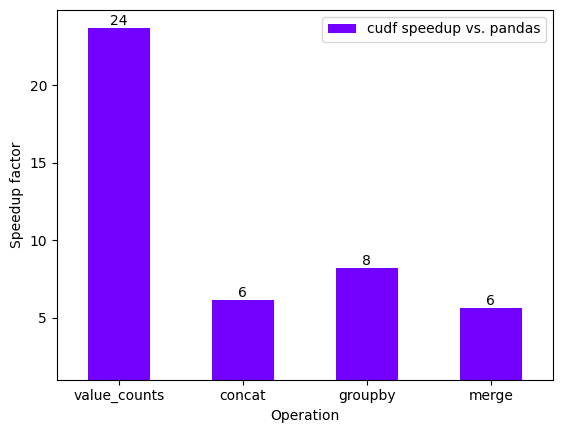

In [16]:
performance_plot(performance_df, xlabel="Operation")

In [17]:
# Cleaning up used memory for later benchmarks
del pdf
del gdf
import gc

_ = gc.collect()

## Strings Performance

In [3]:
timeit_number = 20
num_rows = 100_000_000

In [4]:
pd_series = pd.Series(
    np.random.choice(
        ["123", "56.234", "Walmart", "Costco", "rapids ai"], size=num_rows
    )
)

In [5]:
gd_series = cudf.from_pandas(pd_series)

In [8]:
pandas_upper, cudf_upper = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.upper(), number=timeit_number
)

In [9]:
pandas_contains, cudf_contains = timeit_pandas_cudf(
    pd_series,
    gd_series,
    lambda s: s.str.contains(r"[0-9][a-z]"),
    number=timeit_number,
)

In [10]:
pandas_isalpha, cudf_isalpha = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.str.isalpha(), number=timeit_number
)

In [11]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_upper / cudf_upper,
            pandas_contains / cudf_contains,
            pandas_isalpha / cudf_isalpha,
        ],
    },
    index=["upper", "contains", "isalpha"],
)
performance_df

,cudf speedup vs. pandas
upper,121.972894
contains,52.398546
isalpha,279.836696


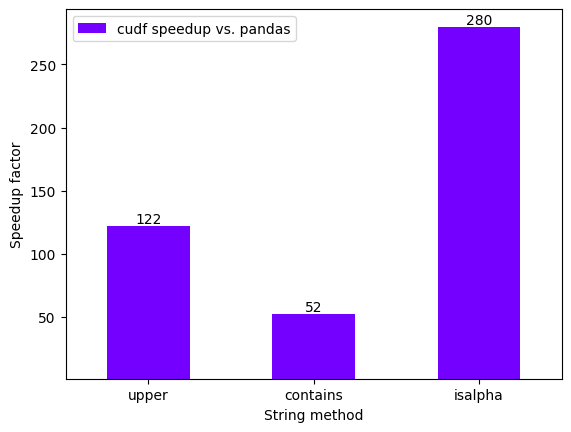

In [14]:
performance_plot(performance_df, xlabel="String method")

## User-defined function (UDF) performance (with JIT overhead)

The first UDF runs include JIT compilation overhead, due to which the performance of first run and average of next few runs are compared separately.

In [15]:
num_rows = 1_000_000

In [16]:
pdf_age = pd.DataFrame(
    {
        "age": np.random.randint(0, 100, num_rows),
    }
)
pdf_age

,age
0,37
1,29
2,18
3,54
4,88
...,...
999995,61
999996,25
999997,65
999998,55


In [17]:
gdf_age = cudf.from_pandas(pdf_age)
gdf_age

,age
0,37
1,29
2,18
3,54
4,88
...,...
999995,61
999996,25
999997,65
999998,55


In [18]:
def age_udf(row):
    if row["age"] < 18:
        return 0
    elif 18 <= row["age"] < 20:
        return 1
    elif 20 <= row["age"] < 30:
        return 2
    elif 30 <= row["age"] < 40:
        return 3
    elif 40 <= row["age"] < 50:
        return 4
    elif 50 <= row["age"] < 60:
        return 5
    elif 60 <= row["age"] < 70:
        return 6
    else:
        return 7

In [19]:
pandas_int_udf, cudf_int_udf = timeit_pandas_cudf(
    pdf_age, gdf_age, lambda df: df.apply(age_udf, axis=1), number=1
)

In [20]:
def str_isupper_udf(row):
    if row.isupper():
        return 0
    else:
        return 1

In [21]:
pd_series = pd.Series(
    np.random.choice(["ABC", "abc", "hello world", "AI"], size=num_rows),
    name="strings",
)
pd_series

0                 ABC
1                  AI
2                  AI
3                 ABC
4                  AI
             ...     
999995            abc
999996            abc
999997    hello world
999998    hello world
999999            ABC
Name: strings, Length: 1000000, dtype: object

In [22]:
gd_series = cudf.from_pandas(pd_series)
gd_series

0                 ABC
1                  AI
2                  AI
3                 ABC
4                  AI
             ...     
999995            abc
999996            abc
999997    hello world
999998    hello world
999999            ABC
Name: strings, Length: 1000000, dtype: object

In [23]:
pandas_str_udf, cudf_str_udf = timeit_pandas_cudf(
    pd_series, gd_series, lambda s: s.apply(str_isupper_udf), number=1
)

In [24]:
performance_df = pd.DataFrame(
    {
        "cudf speedup vs. pandas": [
            pandas_int_udf / cudf_int_udf,
            pandas_str_udf / cudf_str_udf,
        ]
    },
    index=["Numeric", "String"],
)
performance_df

,cudf speedup vs. pandas
Numeric,3.569255
String,1.532017


Below is the plot showing performance speedup in case of Numeric UDFs & String UDFs on their first runs.

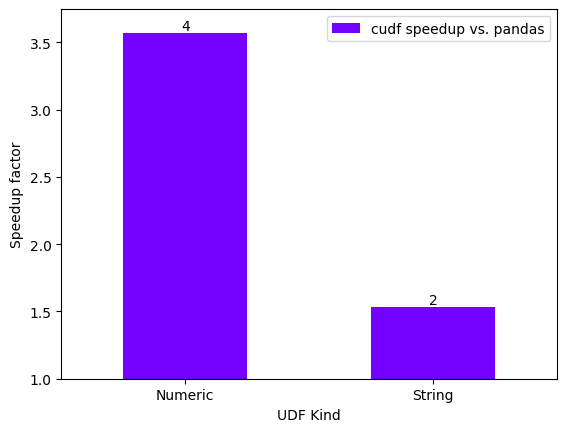

In [25]:
performance_plot(performance_df, xlabel="UDF Kind")

# System Configuration

## CPU Configuration

In [26]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         39 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            13th Gen Intel(R) Core(TM) i5-13400F
    CPU family:          6
    Model:               191
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            2
    BogoMIPS:            4991.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy tsc_reliable nonstop_tsc cpuid pni pclmulqdq ssse3
                          fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx
                          f16c rdrand hypervisor lahf_lm abm 3dnowpref

## GPU Configuration

In [27]:
!nvidia-smi

Tue May 14 16:38:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.01              Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   32C    P8               9W / 165W |   1398MiB / 16380MiB |     15%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--